In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
filename='/Users/arunkumararunachalam/Downloads/ProjectDatasetforCPS584/'

In [3]:
DATASET_PATH = filename

data_dir = pathlib.Path(DATASET_PATH)  
print(DATASET_PATH)

/Users/arunkumararunachalam/Downloads/ProjectDatasetforCPS584/


In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['R' 'U' 'I' 'N' 'G' 'Z' 'T' 'S' 'A' 'F' 'O' 'H' 'M' 'J' 'C' 'D' 'V' 'Q'
 'X' 'E' 'B' 'K' 'L' 'Y' 'P' 'W']


In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Metal device set to: Apple M1 Pro
Number of total examples: 11471
Number of examples per label: 436
Example file tensor: tf.Tensor(b'/Users/arunkumararunachalam/Downloads/ProjectDatasetforCPS584/T/T_381.wav', shape=(), dtype=string)


2022-08-01 19:52:20.993705: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-01 19:52:20.994001: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
train_files = filenames[:9957]
val_files = filenames[9957: 9957 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 9957
Validation set size 800
Test set size 800


In [7]:
test_file = tf.io.read_file(DATASET_PATH+'/A/A_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([20480, 1])

In [8]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [9]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

In [10]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

2022-08-01 19:52:21.168059: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


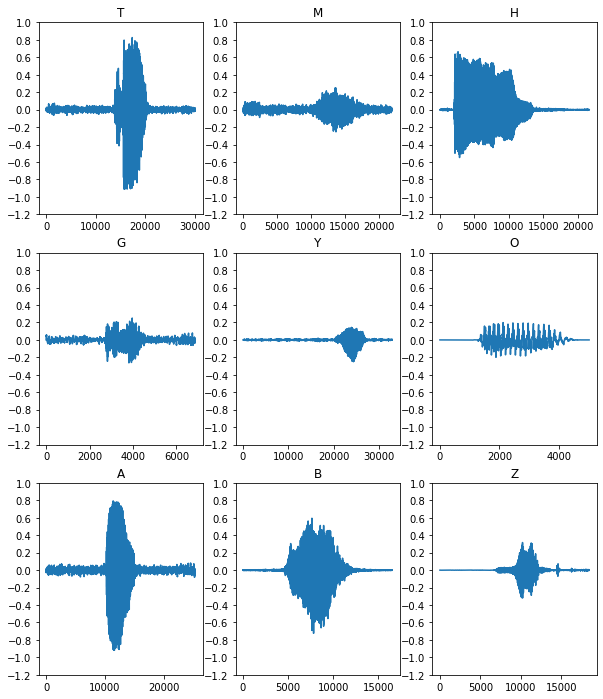

In [12]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [13]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [14]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: T
Waveform shape: (30049,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

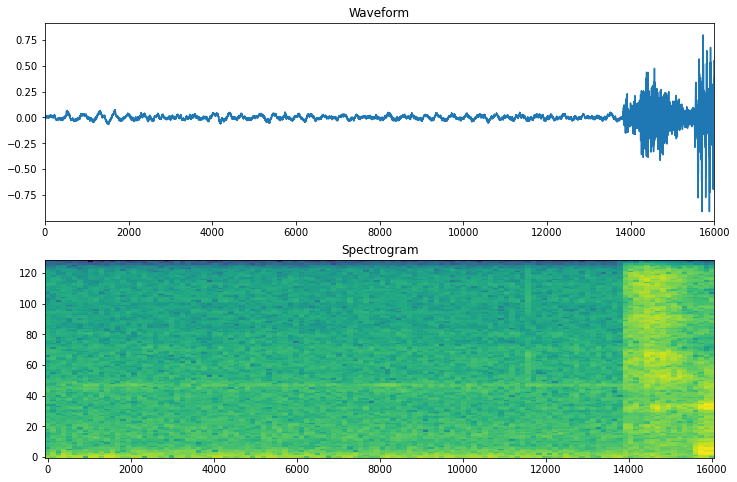

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [17]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == commands)
  return spectrogram, label_id

In [18]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

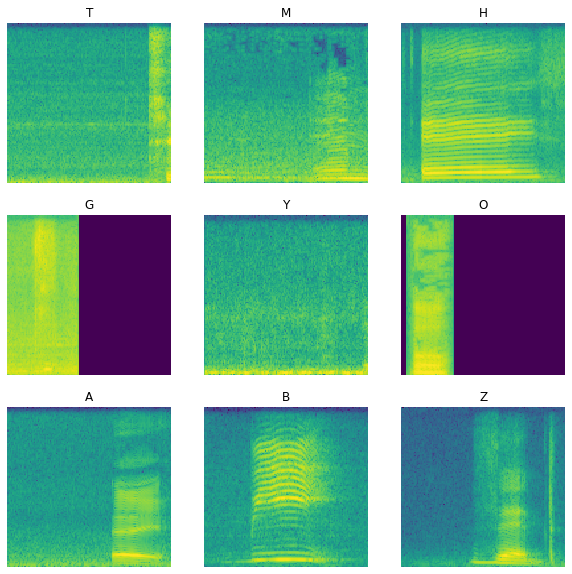

In [19]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [20]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [21]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [22]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [23]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [24]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
# norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [26]:
EPOCHS = 200
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
#     callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/200


2022-08-01 19:52:22.719607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


156/156 [==============================] - ETA: 0s - loss: 3.0320 - accuracy: 0.1121

2022-08-01 19:52:26.510390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


156/156 [==============================] - 4s 24ms/step - loss: 3.0320 - accuracy: 0.1121 - val_loss: 2.7374 - val_accuracy: 0.2025
Epoch 2/200
156/156 [==============================] - 2s 15ms/step - loss: 2.4531 - accuracy: 0.2629 - val_loss: 2.4306 - val_accuracy: 0.2625
Epoch 3/200
156/156 [==============================] - 2s 14ms/step - loss: 1.8875 - accuracy: 0.4206 - val_loss: 2.3817 - val_accuracy: 0.2912
Epoch 4/200
156/156 [==============================] - 2s 13ms/step - loss: 1.4210 - accuracy: 0.5651 - val_loss: 2.4456 - val_accuracy: 0.3275
Epoch 5/200
156/156 [==============================] - 2s 13ms/step - loss: 1.1412 - accuracy: 0.6510 - val_loss: 2.5840 - val_accuracy: 0.3487
Epoch 6/200
156/156 [==============================] - 2s 13ms/step - loss: 0.9576 - accuracy: 0.7129 - val_loss: 2.8699 - val_accuracy: 0.3225
Epoch 7/200
156/156 [==============================] - 2s 13ms/step - loss: 0.8181 - accuracy: 0.7582 - val_loss: 2.8821 - val_accuracy: 0.3650
Epoc

156/156 [==============================] - 2s 12ms/step - loss: 0.0658 - accuracy: 0.9853 - val_loss: 7.7676 - val_accuracy: 0.3875
Epoch 58/200
156/156 [==============================] - 2s 12ms/step - loss: 0.0795 - accuracy: 0.9825 - val_loss: 8.4818 - val_accuracy: 0.3837
Epoch 59/200
156/156 [==============================] - 2s 12ms/step - loss: 0.0910 - accuracy: 0.9787 - val_loss: 8.6953 - val_accuracy: 0.3975
Epoch 60/200
156/156 [==============================] - 2s 12ms/step - loss: 0.0859 - accuracy: 0.9798 - val_loss: 8.3067 - val_accuracy: 0.3713
Epoch 61/200
156/156 [==============================] - 2s 14ms/step - loss: 0.0833 - accuracy: 0.9829 - val_loss: 8.6326 - val_accuracy: 0.3762
Epoch 62/200
156/156 [==============================] - 2s 13ms/step - loss: 0.0795 - accuracy: 0.9840 - val_loss: 8.6562 - val_accuracy: 0.3962
Epoch 63/200
156/156 [==============================] - 2s 13ms/step - loss: 0.0538 - accuracy: 0.9864 - val_loss: 8.4494 - val_accuracy: 0.396

156/156 [==============================] - 2s 13ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 9.6150 - val_accuracy: 0.4112
Epoch 114/200
156/156 [==============================] - 2s 12ms/step - loss: 0.0064 - accuracy: 0.9983 - val_loss: 9.9982 - val_accuracy: 0.4050
Epoch 115/200
156/156 [==============================] - 2s 13ms/step - loss: 0.0171 - accuracy: 0.9970 - val_loss: 10.5214 - val_accuracy: 0.3825
Epoch 116/200
156/156 [==============================] - 2s 14ms/step - loss: 0.0700 - accuracy: 0.9889 - val_loss: 9.5725 - val_accuracy: 0.3987
Epoch 117/200
156/156 [==============================] - 2s 14ms/step - loss: 0.1844 - accuracy: 0.9676 - val_loss: 9.7597 - val_accuracy: 0.3850
Epoch 118/200
156/156 [==============================] - 2s 15ms/step - loss: 0.1377 - accuracy: 0.9756 - val_loss: 8.8857 - val_accuracy: 0.3887
Epoch 119/200
156/156 [==============================] - 2s 16ms/step - loss: 0.0685 - accuracy: 0.9846 - val_loss: 8.6528 - val_accuracy

156/156 [==============================] - 2s 13ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 9.3862 - val_accuracy: 0.3987
Epoch 170/200
156/156 [==============================] - 2s 13ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 9.4541 - val_accuracy: 0.3975
Epoch 171/200
156/156 [==============================] - 2s 13ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 9.4670 - val_accuracy: 0.4000
Epoch 172/200
156/156 [==============================] - 2s 12ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 9.5584 - val_accuracy: 0.4000
Epoch 173/200
156/156 [==============================] - 2s 12ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 9.7351 - val_accuracy: 0.4013
Epoch 174/200
156/156 [==============================] - 2s 12ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 9.6695 - val_accuracy: 0.4025
Epoch 175/200
156/156 [==============================] - 2s 12ms/step - loss: 0.0016 - accuracy: 0.9993 - val_loss: 9.8480 - val_accuracy:

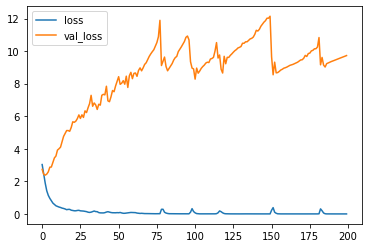

In [27]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

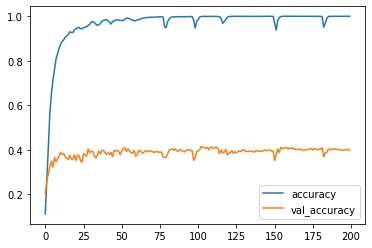

In [28]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [29]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [30]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

25/25 [==============================] - 0s 5ms/step
Test set accuracy: 38%


2022-08-01 19:59:10.330771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


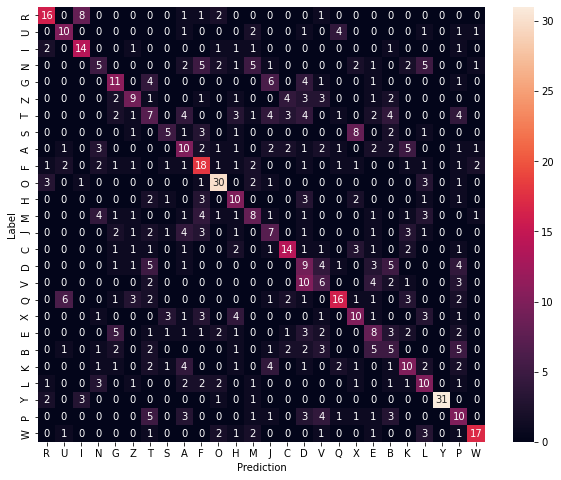

In [31]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

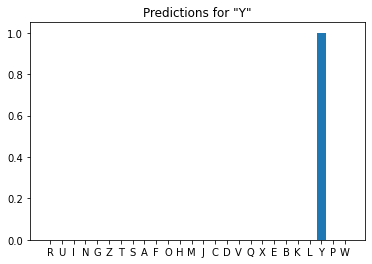

In [34]:
sample_file = data_dir/'Y/Y_158.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()# Saving the tflile model
with open('voice.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/xt/8dzdzjgx2rb2n49z_tlx6ggc0000gn/T/tmp_sy60tgd/assets


INFO:tensorflow:Assets written to: /var/folders/xt/8dzdzjgx2rb2n49z_tlx6ggc0000gn/T/tmp_sy60tgd/assets
2022-08-01 19:59:13.514330: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-08-01 19:59:13.514350: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-08-01 19:59:13.515473: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/xt/8dzdzjgx2rb2n49z_tlx6ggc0000gn/T/tmp_sy60tgd
2022-08-01 19:59:13.516714: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-08-01 19:59:13.516719: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/xt/8dzdzjgx2rb2n49z_tlx6ggc0000gn/T/tmp_sy60tgd
2022-08-01 19:59:13.519842: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-08-01 19:59:13.520539: I tensorflow/cc/saved_model/load